### Introdução

In [1]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,085 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,377 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mai

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/dataset.zip -d /content/

Archive:  /content/drive/MyDrive/dataset.zip
   creating: /content/dataset/
  inflating: /content/dataset/.DS_Store  
  inflating: /content/__MACOSX/dataset/._.DS_Store  
   creating: /content/dataset/text.parquet/
  inflating: /content/__MACOSX/dataset/._text.parquet  
   creating: /content/dataset/Clothing_Shoes_and_Jewelry.parquet/
   creating: /content/dataset/features.parquet/
  inflating: /content/__MACOSX/dataset/._features.parquet  
  inflating: /content/dataset/text.parquet/.part-00072-8f054019-7c1d-4f7c-85d0-bf0440d199a8-c000.snappy.parquet.crc  
  inflating: /content/__MACOSX/dataset/text.parquet/._.part-00072-8f054019-7c1d-4f7c-85d0-bf0440d199a8-c000.snappy.parquet.crc  
  inflating: /content/dataset/text.parquet/.part-00102-8f054019-7c1d-4f7c-85d0-bf0440d199a8-c000.snappy.parquet.crc  
  inflating: /content/__MACOSX/dataset/text.parquet/._.part-00102-8f054019-7c1d-4f7c-85d0-bf0440d199a8-c000.snappy.parquet.crc  
  inflating: /content/dataset/text.parquet/part-00190-8f05401

**Problema de Estudo:** Deteção de Reviews Spam em Produtos de Moda e Acessórios na Amazon.

Pretende-se que seja implementada uma solução computacional para estudo e análise de dados em larga escala.

### Contextualização do problema

Neste projeto, pretende-se desenvolver e implementar um modelo computacional capaz de identificar reviews de produtos da categoria "Clothing, Shoes, and Jewelry" na Amazon como spam ou não spam. O objetivo é diferenciar reviews genuínas de tentativas de manipulação através de avaliações falsas que podem enganar consumidores e distorcer a percepção do produto. Este problema é particularmente desafiador devido à subjetividade e variabilidade do texto das reviews, bem como às diferentes motivações por trás das reviews spam.

**Dados**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from pyspark.sql import SparkSession

# Criar uma sessão Spark
spark = SparkSession.builder \
    .appName("Clothing_Shoes_and_Jewelry_Analysis") \
    .getOrCreate()


In [ ]:
# Caminho para o arquivo JSON
file_path = "Clothing_Shoes_and_Jewelry.json"

# Carregar o dataset
df = spark.read.json(file_path)

In [ ]:
# Mostrar as primeiras 5 linhas do dataframe
df.show(5)

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  0.0| [0, 1]|    1.0|My 3-yr-old daugh...|03 21, 2013| A19PBP93OF896|Alinna Satake "Ca...|Tiny and Poorly C...|    1363824000|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|This was a really...|05 26, 2012|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|Really Cute but r...|    1337990400|
|{5a132293741a2384...|0000031887|Clothing_Shoes_an...|  1.0| [0, 0]|    5.0|Perfect red tu

In [ ]:
# Ver a estrutura dos dados
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [ ]:
# Verificar o número de linhas do dataframe
rows = df.count()
rows

5504331

In [ ]:
# Verificar o número de colunas do dataframe
cols = len(df.columns)
cols

12

In [ ]:
# Colunas do dataframe
cols = df.columns
cols

['_id',
 'asin',
 'category',
 'class',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime']

**'_id':** Identificador único de cada review

**'asin':** Amazon Standard Identification Number, que é um identificador único para produtos na plataforma da Amazon

**'category':** Categoria do produto da review, que indica a que segmento do mercado o produto pertence, como roupas, sapatos ou joias

**'class':** Distingue reviews como spam (1.0) ou não spam (0.0)

**'helpful':** Array que contém dois números, onde o primeiro indica quantas pessoas acharam a review útil e o segundo quantas pessoas votaram na utilidade da review

**'overall':** Nota geral dada ao produto pelo usuário

**'reviewText':** Texto completo da review escrita pelo usuário

**'reviewTime':** Data em que a review foi publicada

**'reviewerID':** Identificador único da pessoa que escreveu a avaliação

**'reviewerName':** Nome ou pseudonimo do revisor, conforme apresentado na Amazon no momento da review

**'summary':** Resumo da review, que é uma breve descrição ou título que foi dada na avaliação

**'unixReviewTime':** Representação em timestamp UNIX da data de publicação da review

### Preparação dos Dados

- Valores omissos

In [ ]:
# Verificar os valores omissos
from pyspark.sql.functions import col, isnull, when, count

missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+
|_id|asin|category|class|helpful|overall|reviewText|reviewTime|reviewerID|reviewerName|summary|unixReviewTime|
+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+
|  0|   0|       0|    0|      0|      0|         0|         0|         0|       13180|      0|             0|
+---+----+--------+-----+-------+-------+----------+----------+----------+------------+-------+--------------+



- Duplicados

In [ ]:
# Remover os duplicados recorrendo ao método dropDuplicates
original_count = df.count()
df = df.dropDuplicates()
new_count = df.count()

duplicates_count = original_count - new_count
print(f"Number of duplicate rows: {duplicates_count}")

df.show(5)

Number of duplicate rows: 0


+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a13229b741a2384...|B0008EOEPK|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|Lee straight leg,...| 01 1, 2014|A2HJ1VX57R6M6L|         Smiling Bob|     Excellent Jeans|    1388534400|
|{5a132298741a2384...|B00075ZYRW|Clothing_Shoes_an...|  1.0| [0, 0]|    4.0|Fits 3x. After wa...| 01 1, 2014|A3VTTTYIB5BANY|           fabfamily|liked them. order...|    1388534400|
|{5a132296741a2384...|B00023JSDA|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|The quality/wo

- Remover caracteres especiais da coluna '_id'

In [ ]:
#Remover caracteres especiais da coluna '_id'
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace

cleaned_df = df.withColumn("_id", col("_id").getField("$oid"))
cleaned_df = cleaned_df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

cleaned_df.show()

+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|            category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+--------------------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a132293741a2384e...|0000031887|Clothing_Shoes_an...|  0.0| [0, 1]|    1.0|My 3-yr-old daugh...|03 21, 2013| A19PBP93OF896|Alinna Satake "Ca...|Tiny and Poorly C...|    1363824000|
|5a132293741a2384e...|0000031887|Clothing_Shoes_an...|  1.0| [1, 1]|    4.0|This was a really...|05 26, 2012|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|Really Cute but r...|    1337990400|
|5a132293741a2384e...|0000031887|Clothing_Shoes_an...|  1.0| [0, 0]|    5.0|Perfect red tu

- Remover colunas que não são relevantes para o estudo

In [ ]:
# Remover colunas que não são necessárias para o problema em questão
cleaned_df = cleaned_df.drop( 'category')
#cleaned_df = cleaned_df.drop( 'category', 'asin' , 'reviewerID', 'reviewerName')

cleaned_df.show()

+--------------------+----------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|class|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a132293741a2384e...|0000031887|  0.0| [0, 1]|    1.0|My 3-yr-old daugh...|03 21, 2013| A19PBP93OF896|Alinna Satake "Ca...|Tiny and Poorly C...|    1363824000|
|5a132293741a2384e...|0000031887|  1.0| [1, 1]|    4.0|This was a really...|05 26, 2012|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|Really Cute but r...|    1337990400|
|5a132293741a2384e...|0000031887|  1.0| [0, 0]|    5.0|Perfect red tutu ...| 11 4, 2013|A2XVJBSRI3SWDI|             abigail|           Nice tutu|    1383523200|
|5a132293741a2384e...|0000031887| 

- Renomear algumas colunas

In [ ]:
# Renomear as colunas 'overall' e '-id'
cleaned_df = cleaned_df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")

In [ ]:
cleaned_df.show()

+--------------------+-----+-------+-------------+--------------------+-----------+--------------------+--------------+
|                  id|class|helpful|productRating|          reviewText| reviewTime|             summary|unixReviewTime|
+--------------------+-----+-------+-------------+--------------------+-----------+--------------------+--------------+
|5a13229b741a2384e...|  1.0| [0, 0]|          4.0|Lee straight leg,...| 01 1, 2014|     Excellent Jeans|    1388534400|
|5a132298741a2384e...|  1.0| [0, 0]|          4.0|Fits 3x. After wa...| 01 1, 2014|liked them. order...|    1388534400|
|5a132296741a2384e...|  1.0| [1, 1]|          4.0|The quality/workm...|01 10, 2007|     Garnet Necklace|    1168387200|
|5a132298741a2384e...|  1.0| [0, 0]|          5.0|These are perfect...|01 10, 2013|Perfect comfy fit...|    1357776000|
|5a132294741a2384e...|  1.0| [0, 1]|          5.0|I bought two of t...|01 10, 2013|A Perfect First W...|    1357776000|
|5a132296741a2384e...|  1.0| [2, 2]|    

- Modifica a coluna 'helpful' para refletir a taxa de votos uteis

In [ ]:
# Colocar o número de votos recebidos como uma métrica de 'Helpful'
cleaned_df = cleaned_df.withColumn('reviewUpvotes', col('helpful')[0])

#cleaned_df.show()

In [ ]:
# Modificar a coluna 'helpful' original para um valor float que mostra o número de pessoas que acharam útil entre o total de pessoas que a viram
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0  # retorna 0.0 se não houver votos
    except:
        return None

# UDF para calcular a taxa de votos úteis
ratio_udf = udf(helpful_ratio, FloatType())

# Aplicar a UDF ao DataFrame
cleaned_df =  cleaned_df.withColumn('helpful', ratio_udf(col('helpful')))

In [ ]:
cleaned_df.show()

+--------------------+-----+-------+-------------+--------------------+-----------+--------------------+--------------+-------------+
|                  id|class|helpful|productRating|          reviewText| reviewTime|             summary|unixReviewTime|reviewUpvotes|
+--------------------+-----+-------+-------------+--------------------+-----------+--------------------+--------------+-------------+
|5a132293741a2384e...|  0.0|    0.0|          1.0|My 3-yr-old daugh...|03 21, 2013|Tiny and Poorly C...|    1363824000|            0|
|5a132293741a2384e...|  1.0|  100.0|          4.0|This was a really...|05 26, 2012|Really Cute but r...|    1337990400|            1|
|5a132293741a2384e...|  1.0|    0.0|          5.0|Perfect red tutu ...| 11 4, 2013|           Nice tutu|    1383523200|            0|
|5a132293741a2384e...|  1.0|    0.0|          4.0|Bought it for my ...|01 23, 2014|           i love it|    1390435200|            0|
|5a132293741a2384e...|  1.0|    0.0|          5.0|This is a gr

In [ ]:
# Renomear a coluna 'helpful' para 'helpfulTotalRatio'
cleaned_df =cleaned_df.withColumnRenamed("helpful", "helpfulTotalRatio")

In [ ]:
cleaned_df.columns

['id',
 'asin',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes']

- Converte a coluna 'reviewTime' para o formato de data

In [ ]:
# Converter a coluna 'reviewTime' para o formato de data
from pyspark.sql.functions import to_timestamp

cleaned_df = cleaned_df.withColumn("reviewTime", to_timestamp("reviewTime", "MM dd, yyyy"))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|         reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+
|5a132293741a2384e...|0000031887|  0.0|              0.0|          1.0|My 3-yr-old daugh...|2013-03-21 00:00:00| A19PBP93OF896|Alinna Satake "Ca...|Tiny and Poorly C...|    1363824000|            0|
|5a132293741a2384e...|0000031887|  1.0|            100.0|          4.0|This was a really...|2012-05-26 00:00:00|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|Really Cute but r...|    1337990400|            1|
|5a13

- Transformação dos dados: remover pontuações, passar o texto para minusculas, ...

In [ ]:
import pyspark.sql.functions as F

# Converter todos os caracteres para minúsculas
cleaned_df = cleaned_df.withColumn('reviewText', F.lower(cleaned_df['reviewText']))

# Remover código HTML
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '<[^>]+>', ''))

# Remover URLs
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], 'http\S+|www\S+|https?\:\/\/\S+', ''))

# Remover menções a usuários (não é comum em reviews da Amazon)
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '@\w+', ''))

# Remover hashtags (não é comum em reviews da Amazon)
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '#\w+', ''))

# Remover entidades HTML (&amp;, &lt;, etc.)
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '&\w+;', ''))

# Substituir caracteres não alfanuméricos e pontuação por um espaço em branco
cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '[^\w\s]', ' '))

# Remover números (avaliações numéricas, preços, etc.)
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '\d+', ''))

# Substituir dígitos por um espaço em branco
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '\d', ' '))

# Remover espaços múltiplos e linhas novas
#cleaned_df = cleaned_df.withColumn('reviewText', F.regexp_replace(cleaned_df['reviewText'], '\s+', ' '))

# Remover espaços no início e no fim
#cleaned_df = cleaned_df.withColumn('reviewText', F.trim(cleaned_df['reviewText']))

# cleaned_df.show(truncate=False)


In [ ]:
from pyspark.sql.functions import col, lower, regexp_replace

cleaned_df = cleaned_df.withColumn("summary", lower(col("summary")))\
                 .withColumn("summary", regexp_replace(col("summary"), "[^\w\s]", ""))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|         reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+
|5a132293741a2384e...|0000031887|  0.0|              0.0|          1.0|my 3 yr old daugh...|2013-03-21 00:00:00| A19PBP93OF896|Alinna Satake "Ca...|tiny and poorly c...|    1363824000|            0|
|5a132293741a2384e...|0000031887|  1.0|            100.0|          4.0|this was a really...|2012-05-26 00:00:00|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|really cute but r...|    1337990400|            1|
|5a13

- Adiciona uma coluna que indica se a review foi feita no fim de semana

In [ ]:
from pyspark.sql.functions import col, dayofweek, when

# Adicionar uma coluna 'isWeekend' que indica se a review foi feita no fim de semana
cleaned_df = cleaned_df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))

In [ ]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+---------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|         reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|isWeekend|
+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+---------+
|5a132293741a2384e...|0000031887|  0.0|              0.0|          1.0|my 3 yr old daugh...|2013-03-21 00:00:00| A19PBP93OF896|Alinna Satake "Ca...|tiny and poorly c...|    1363824000|            0|        0|
|5a132293741a2384e...|0000031887|  1.0|            100.0|          4.0|this was a really...|2012-05-26 00:00:00|A2G0LNLN79Q6HR|       aj_18 "Aj_18"|really cute but 

- Criar colunas que indicam o comprimento da review e do sumário

In [ ]:
from pyspark.sql.functions import length

# Adicionar colunas que indicam o comprimento da review e do sumário
cleaned_df = cleaned_df.withColumn('reviewLength', length(cleaned_df['reviewText']))
cleaned_df = cleaned_df.withColumn('summaryLength', length(cleaned_df['summary']))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|         reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|isWeekend|reviewLength|summaryLength|
+--------------------+----------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+
|5a132293741a2384e...|0000031887|  0.0|              0.0|          1.0|my 3 yr old daugh...|2013-03-21 00:00:00| A19PBP93OF896|Alinna Satake "Ca...|tiny and poorly c...|    1363824000|            0|        0|         672|           27|
|5a132293741a2384e...|0000031887|  1.0|            100.0

- Bucketing

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import Bucketizer

# Calcular a popularidade do produto
product_popularity_df = cleaned_df.groupBy('asin').agg(F.count('*').alias('productPopularity'))
cleaned_df = cleaned_df.join(product_popularity_df, on='asin', how='left')

# Calcular a média das avaliações do produto
product_avg_rating_df = cleaned_df.groupBy('asin').agg(F.avg('productRating').alias('avgProductRating'))
cleaned_df = cleaned_df.join(product_avg_rating_df, on='asin', how='left')

# Criar um Bucketizer para dividir a coluna 'helpfulTotalRatio' em 3 categorias
bucketizer = Bucketizer(splits=[0, 33.3, 66.6, 100], inputCol="helpfulTotalRatio", outputCol="helpfulRatioCategory")
cleaned_df = bucketizer.setHandleInvalid("keep").transform(cleaned_df)

# Converter a coluna 'helpfulRatioCategory' de numérica para categórica
cleaned_df = cleaned_df.withColumn("helpfulRatioCategory",
                   F.when(F.col("helpfulRatioCategory") == 0, "Low")\
                    .when(F.col("helpfulRatioCategory") == 1, "Medium")\
                    .otherwise("High"))

# Criar uma coluna que indica se a review contém uma pergunta
cleaned_df = cleaned_df.withColumn('containsQuestion', (F.col('reviewText').like('%?%')).cast('integer'))

In [ ]:
cleaned_df.columns

['asin',
 'id',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes',
 'isWeekend',
 'reviewLength',
 'summaryLength',
 'productPopularity',
 'avgProductRating',
 'helpfulRatioCategory',
 'containsQuestion']

In [ ]:
cleaned_df.show()

+----------+--------------------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+-----------------+------------------+--------------------+----------------+
|      asin|                  id|class|helpfulTotalRatio|productRating|          reviewText|         reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|isWeekend|reviewLength|summaryLength|productPopularity|  avgProductRating|helpfulRatioCategory|containsQuestion|
+----------+--------------------+-----+-----------------+-------------+--------------------+-------------------+--------------+--------------------+--------------------+--------------+-------------+---------+------------+-------------+-----------------+------------------+--------------------+----------------+
|0456787283|5a132293741a2384e...|  0.0|            100.0|          

### Balanceamento do dataset

In [ ]:
cleaned_df.groupBy('class').count().show()

+-----+-------+
|class|  count|
+-----+-------+
|  0.0|1169449|
|  1.0|4334882|
+-----+-------+



In [ ]:
# Calcular a taxa de balanceamento
num_minority = cleaned_df.filter(cleaned_df['class'] == 0.0).count()
num_majority = cleaned_df.filter(cleaned_df['class'] == 1.0).count()
balance_ratio = num_minority / num_majority

# Aplicar undersampling
undersampled_df = cleaned_df.filter(cleaned_df['class'] == 0.0).union(
    cleaned_df.filter(cleaned_df['class'] == 1.0).sample(False, balance_ratio)
)

undersampled_df.groupBy('class').count().show()

+-----+-------+
|class|  count|
+-----+-------+
|  0.0|1169449|
|  1.0|1170053|
+-----+-------+



### Relações entre as variáveis

**Construção do modelo com Algoritmos de Machine Learning**

**Modelo 1: Regressão Logística**

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, length, dayofweek, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Bucketizer
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os

spark = SparkSession.builder \
    .appName("LogisticRegressionExample") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.default.parallelism", 200) \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.instances", "2") \
    .config("spark.network.timeout", "800s") \
    .config("spark.rpc.message.maxSize", "256") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

# File paths
json_file_path = "Clothing_Shoes_and_Jewelry.json"
parquet_file_path = "dataset/Clothing_Shoes_and_Jewelry.parquet"

# parquet_file_path_features = "dataset/features.parquet"
parquet_file_path_features = None

parquet_file_path_text = "dataset/text.parquet"
# parquet_file_path_text = None

# Check if the Parquet file exists
if os.path.exists(parquet_file_path):
    # Load the DataFrame from the Parquet file
    if parquet_file_path_features is None and parquet_file_path_text is not None:
        df = spark.read.parquet(parquet_file_path_text)
    elif parquet_file_path_features is not None:
        df = spark.read.parquet(parquet_file_path_features)
    else:
        df = spark.read.parquet(parquet_file_path)
else:
    # Load the DataFrame from the JSON file
    df = spark.read.json(json_file_path)

    # Sample the DataFrame
    df = df.sample(fraction=0.1, seed=12345)

    # Write the DataFrame to a Parquet file
    df.write.parquet(parquet_file_path)
    print("Data written to Parquet file.")


# Continue with your data processing
# Example: Show the DataFrame schema and first few rows
df.printSchema()
df.show(5)

root
 |-- reviewText: string (nullable = true)
 |-- class: double (nullable = true)

+--------------------+-----+
|          reviewText|class|
+--------------------+-----+
|the quality is go...|  1.0|
|i thought it woul...|  0.0|
|best present to g...|  1.0|
|this is supposed ...|  0.0|
|this hat arrived ...|  1.0|
+--------------------+-----+
only showing top 5 rows



In [5]:
from pyspark.sql.functions import col, regexp_replace, length, dayofweek, when
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
from pyspark.ml.feature import Bucketizer
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf

# Assuming a SparkSession is already created

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1]) * 100
    except ZeroDivisionError:
        return 0.0
    except:
        return None

ratio_udf = udf(helpful_ratio, FloatType())

def feature_engineering(df, process=False):

    if process:
        # Fase 1 Limpeza de Dados
        df = df.withColumn("_id", col("_id").getField("$oid"))
        df = df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))
        df = df.drop('category')
        df = df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")
        df = df.withColumn('reviewUpvotes', col('helpful')[0])
        df = df.withColumn('helpful', ratio_udf(col('helpful')))
        df = df.withColumnRenamed("helpful", "helpfulTotalRatio")
        df = df.withColumn('reviewLength', length(df['reviewText']))
        df = df.withColumn('summaryLength', length(df['summary']))
        df = df.withColumn('reviewTime', col('reviewTime').cast('timestamp'))
        df = df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))

        product_popularity_df = df.groupBy('asin').agg(F.count('*').alias('productPopularity'))
        df = df.join(product_popularity_df, on='asin', how='left')
        product_avg_rating_df = df.groupBy('asin').agg(F.avg('productRating').alias('avgProductRating'))
        df = df.join(product_avg_rating_df, on='asin', how='left')

        bucketizer = Bucketizer(splits=[0, 33.3, 66.6, 100], inputCol="helpfulTotalRatio", outputCol="helpfulRatioCategory")
        df = bucketizer.setHandleInvalid("keep").transform(df)
        df = df.withColumn("helpfulRatioCategory",
                        F.when(F.col("helpfulRatioCategory") == 0, "Low")\
                            .when(F.col("helpfulRatioCategory") == 1, "Medium")\
                            .otherwise("High"))
        df = df.withColumn('containsQuestion', (F.col('reviewText').like('%?%')).cast('integer'))
        df = df.withColumn('containsLink', (F.col('reviewText').like('%http%')).cast('integer'))

        # Return all columns except 'reviewText' and 'summary'
        cols_to_return = [col for col in df.columns if col not in ['reviewText', 'summary']]
        df = df.select(*cols_to_return)

        df.write.parquet("dataset/features.parquet", mode='overwrite')
    else:
        df = None


    return df

def text_processing(df, process=False):

    if process:
        df = df.withColumn('reviewText', F.lower(df['reviewText']))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '<[^>]+>', ''))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], 'http\\S+|www\\S+|https?://\\S+', ''))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '@\\w+', ''))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '#\\w+', ''))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '&\\w+;', ''))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '[^\\w\\s]', ' '))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '\\d+', ''))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '\\d', ' '))
        df = df.withColumn('reviewText', F.regexp_replace(df['reviewText'], '\\s+', ' '))
        df = df.withColumn('reviewText', F.trim(df['reviewText']))

        df = df.withColumn('summary', F.lower(df['summary']))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '<[^>]+>', ''))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], 'http\\S+|www\\S+|https?://\\S+', ''))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '@\\w+', ''))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '#\\w+', ''))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '&\\w+;', ''))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '[^\\w\\s]', ' '))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '\\d+', ''))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '\\d', ' '))
        df = df.withColumn('summary', F.regexp_replace(df['summary'], '\\s+', ' '))
        df = df.withColumn('summary', F.trim(df['summary']))

        # Return only 'reviewText' and 'summary'
        df = df.select('reviewText', 'class')

        df.write.parquet("dataset/text.parquet", mode='overwrite')
    else:
        df = None


    return df


df_features = feature_engineering(df, False)
df_text = text_processing(df, False)

# Save DataFrames to Parquet files


In [6]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql.functions import to_timestamp, col, regexp_replace
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.storagelevel import StorageLevel
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Assuming df is already defined and loaded with data
# Checking for class imbalance
class_distribution = df.groupBy("class").count().orderBy("class")
class_distribution.show()

# Undersample the majority class
min_class_count = class_distribution.agg({"count": "min"}).collect()[0][0]
print("Minimum class count:", min_class_count)

undersampled_df = df.groupBy("class").applyInPandas(
    lambda pdf: pdf.sample(n=min_class_count, random_state=42) if len(pdf) > min_class_count else pdf,
    schema=df.schema
)

undersampled_df.show()

# Preprocessing stages
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Split the data into training and testing sets
train_df, test_df = undersampled_df.randomSplit([0.8, 0.2], seed=42)

train_df.persist(StorageLevel.MEMORY_AND_DISK)


+-----+------+
|class| count|
+-----+------+
|  0.0|116697|
|  1.0|433782|
+-----+------+

Minimum class count: 116697
+--------------------+-----+
|          reviewText|class|
+--------------------+-----+
|i thought it woul...|  0.0|
|this is supposed ...|  0.0|
|i got this for my...|  0.0|
|we got this to go...|  0.0|
|beware that this ...|  0.0|
|even for an adult...|  0.0|
|is wonderful for ...|  0.0|
|these suspenders ...|  0.0|
|this is a super c...|  0.0|
|i love the look o...|  0.0|
|my th grade son u...|  0.0|
|nice size and was...|  0.0|
|bottoms fit a lit...|  0.0|
|overall this was ...|  0.0|
|unfortunately its...|  0.0|
|i purchased this ...|  0.0|
|the size itself i...|  0.0|
|shipped wrong col...|  0.0|
|these shoes were ...|  0.0|
|the dress its per...|  0.0|
+--------------------+-----+
only showing top 20 rows



DataFrame[reviewText: string, class: double]

Training Logistic Regression...
Logistic Regression Test Accuracy = 0.80
Class 0.0:
  Precision = 0.80
  Recall = 0.80
  F1 Score = 0.80
Class 1.0:
  Precision = 0.80
  Recall = 0.80
  F1 Score = 0.80


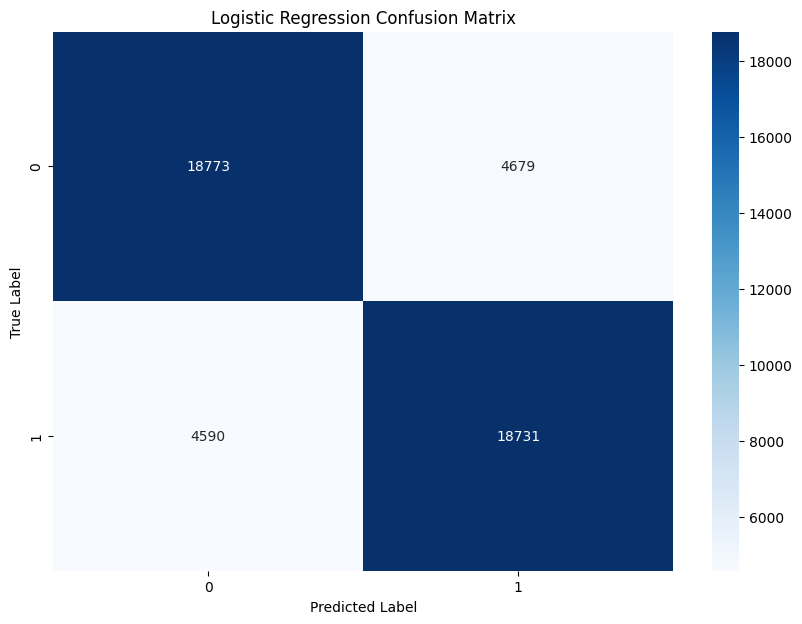

In [7]:
# Logistic Regression Model
model = LogisticRegression(labelCol="class")
model_name = "Logistic Regression"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

Training Decision Tree...
Decision Tree Test Accuracy = 0.71
Class 0.0:
  Precision = 0.67
  Recall = 0.83
  F1 Score = 0.74
Class 1.0:
  Precision = 0.77
  Recall = 0.59
  F1 Score = 0.67


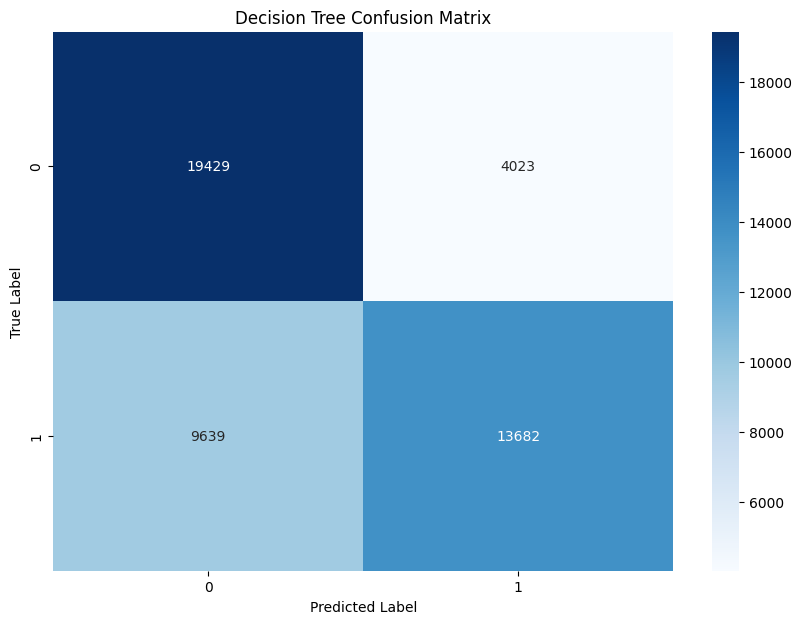

In [8]:
# Decision Tree Model
model = DecisionTreeClassifier(labelCol="class", maxDepth=5)
model_name = "Decision Tree"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

In [ ]:
# Random Forest Model
model = RandomForestClassifier(labelCol="class")
model_name = "Random Forest"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

Training Random Forest...


In [ ]:
# Gradient-Boosted Trees Model
model = GBTClassifier(labelCol="class")
model_name = "Gradient-Boosted Trees"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

Training Gradient-Boosted Trees...


24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:53 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/06/04 14:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
24/06/04 14:17:57 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/06/04 14:18:03 WARN MemoryStore: Not enough space to cache rdd_77_5 in memory! (computed 951.0 MiB so far)
24/06/04 14:18:03 WARN BlockManager: Persisting block rdd_77_5 to disk instead.
24/06/04 14:18:04 WARN BlockManager: Block rdd_77_58 could not be removed as it was not found on disk or in memory
24/06/04 14:18:04 ERROR Executor: Exception in task 58.0 in stage 32.0 (TID 1902)
java.lan

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49951)
Traceback (most recent call last):
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 267, in poll
 

ConnectionRefusedError: [Errno 61] Connection refused

Training SVM...


24/06/04 14:11:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/04 14:11:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:11:50 WARN DAGSchedul

SVM Test Accuracy = 0.90


24/06/04 14:13:58 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/04 14:14:00 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


Class 0.0:
  Precision = 0.90
  Recall = 0.90
  F1 Score = 0.90
Class 1.0:
  Precision = 0.90
  Recall = 0.90
  F1 Score = 0.90


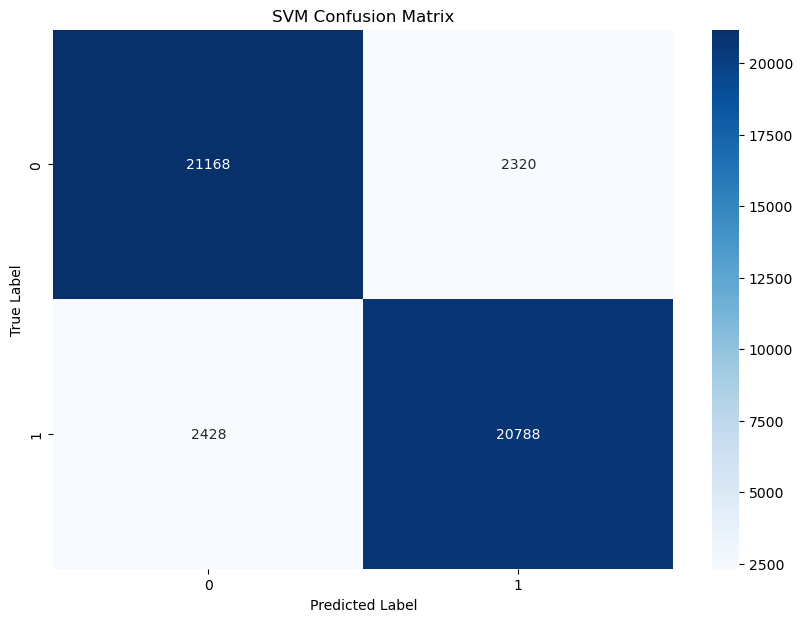

In [ ]:
# SVM Model
model = LinearSVC(labelCol="class")
model_name = "SVM"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

### NOTAS

• Por questões de produtividade, devem ser considerados dois conjuntos de dados aquando do desenvolvimento da solução. Assim, para além dos dados originais na sua integra, deve ser utilizado um conjunto de dados de menor dimensão (sub-conjunto dos anteriores), para o caso de tarefas intensivas e frequentes, inerentes ao próprio processo de desenvolvimento da solução.

• Cada notebook (ou módulo) deverá ser autónomo em termos de fontes de dados. Sugere se que estruturem o código por forma a ler e gravar os dados entre cada uma das etapas do projeto. Isto é particularmente importante para a parte da visualização: a geração
de um gráfico ou tabela não deverá implicar a realização da simulação/processamento no mesmo instante. Preferencialmente deverá importar os dados já processados a partir de ficheiros.

### Bibliografia

https://www.kaggle.com/datasets/naveedhn/amazon-product-review-spam-and-non-spam/data?select=Clothing_Shoes_and_Jewelry     https://ieeexplore.ieee.org/abstract/document/9027828

https://www.kaggle.com/code/abhilashsampath/amazon-review-spam-detection